

# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> Data Science 2: Advanced Topics in Data Science 
## Homework 7 - Generative Models - Autoencoders and GANs 



**Harvard University**<br/>
**Spring 2019**<br/>
**Instructors**: Pavlos Protopapas and Mark Glickman 


<hr style="height:2pt">

### INSTRUCTIONS

- This is individual homework - No collaboration/Groups
- To submit your assignment follow the instructions given in canvas.
- Restart the kernel and run the whole notebook again before you submit (excluding large networks)
- Please note that the model training in this assignment can take a long time (even on a GPU). Expect to train for more than 2-3hrs per model.

<hr style="height:2pt">

In [1]:
#PLEASE RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

In [90]:
#PLEASE RUN THIS CELL 
import requests
import os
import glob, cv2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from skimage.io import imread
import skimage.transform
from scipy.misc import imresize
from scipy.stats import norm
from sklearn.model_selection import train_test_split

from keras import backend as K
from keras_preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.callbacks import EarlyStopping
from keras.models import Sequential, Model, load_model
from keras.layers import Dropout, Flatten, Dense, Conv2D, MaxPooling2D, Input, Reshape, UpSampling2D, InputLayer, Lambda, ZeroPadding2D, Cropping2D, Conv2DTranspose, BatchNormalization
from keras.utils import np_utils, to_categorical
from keras.losses import binary_crossentropy
from keras import backend as K,objectives
from keras.losses import mse, binary_crossentropy
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam, RMSprop
from keras.initializers import RandomNormal
from keras.layers import *
import random
import utils
from IPython.display import clear_output

from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

## Question 1: Making Faces [97 pts]  </b></div>

We'll be using a subset of the Celeb A dataset to help us build facial generative models, as described on the [Celeb A](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) website. CelebFaces Attributes Dataset (CelebA) is a large-scale face attributes dataset with more than 200K celebrity images, each with 40 attribute annotations. The images in this dataset cover large pose variations and background clutter. 

CelebA has large diversities, large quantities, and rich annotations, including

- 10,177 number of identities,
- 202,599 number of face images, 
- 5 landmark locations, and 
- 40 binary attributes annotations per image.

### Part A:  Preparing the Data [10 pts]

**1.A.1.** Download the dataset from: [CelebA Dataset](https://s3.amazonaws.com/gec-harvard-dl2-hw2-data/datasets/celeba-dataset.zip). In the provided data you'll see the `img_align_celeba` directory. The images in that directory will form your dataset.  You may want to create a [Keras Custom Data Generator](https://techblog.appnexus.com/a-keras-multithreaded-dataframe-generator-for-millions-of-image-files-84d3027f6f43).  

**1.A.2.** Load the attribute data in `list_attr_celeba.csv` into a pandas dataframe.

**1.A.3.** Pick 3 random images from the dataset, plot them, and verify that the attributes are accurate.

In [3]:
# 1.A.1 create an image Data Generator
# Pull in the evaluation partitions with the associated image IDs
celebaEval = pd.read_csv('data/list_eval_partition.csv')
display(celebaEval.head())
# Train data is the 0 partition
trainData = celebaEval[celebaEval.partition == 0]
trainData = trainData.sample(frac=0.25, replace=True, random_state=109)
trainData = trainData.reset_index()
# Validation data is the 2 partition
validData = celebaEval[celebaEval.partition == 2]
validData = validData.sample(frac=0.25, replace=True, random_state=109)
validData = validData.reset_index()

batch_size = 16
print("There are {} images in the training data and {} images in the validation data.".format(trainData.shape[0],validData.shape[0]))
# Create an image generator
celebGeneratorTrain = ImageDataGenerator(rescale=1. / 255,zoom_range = 0.1)
trainGenerator = celebGeneratorTrain.flow_from_dataframe(dataframe=trainData, directory="data/img_align_celeba", x_col="image_id", y_col="partition", class_mode='input', target_size=(128,128), batch_size=batch_size)
celebGeneratorValid = ImageDataGenerator(rescale=1./255)
validGenerator = celebGeneratorValid.flow_from_dataframe(dataframe=validData, directory="data/img_align_celeba", x_col="image_id", y_col="partition", class_mode='input', target_size=(128,128), batch_size=batch_size)

,image_id,partition
0,000001.jpg,0
1,000002.jpg,0
2,000003.jpg,0
3,000004.jpg,0
4,000005.jpg,0


There are 40692 images in the training data and 4990 images in the validation data.


/usr/share/anaconda3/lib/python3.6/site-packages/keras_preprocessing/image.py:2059: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.df[x_col] = self.df[x_col].astype(str)


Found 36000 images.
Found 4435 images.


In [4]:
# 1.A.2 Load attribute data 
celebaAttr = pd.read_csv('data/list_attr_celeba.csv')
display(celebaAttr.shape)
display(celebaAttr.head())

(202599, 41)

,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,1,-1,1,1,-1,1
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1


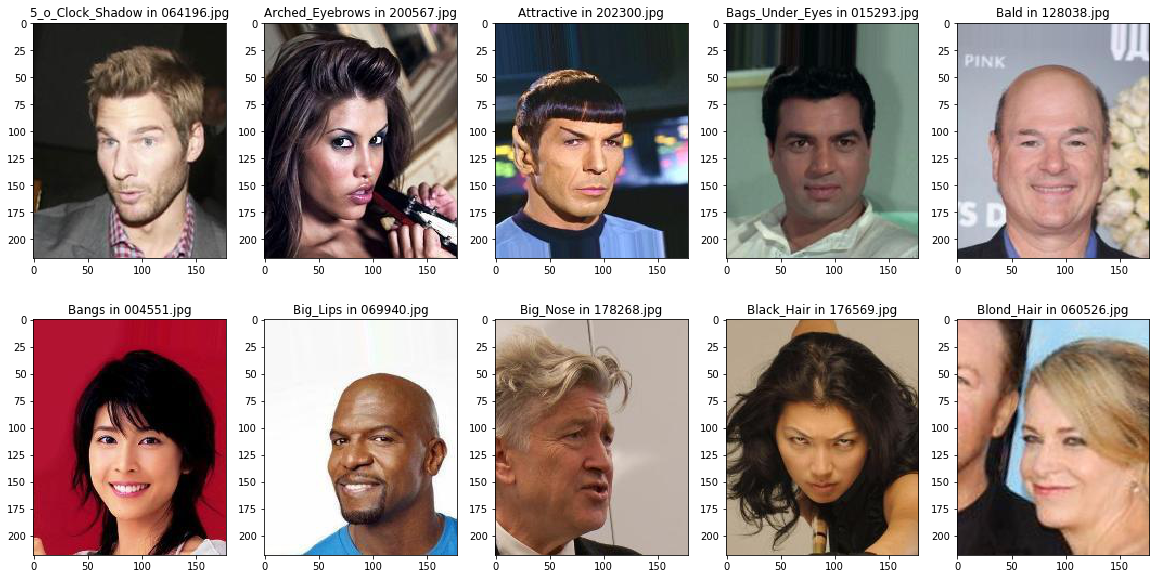

In [55]:
# 1.A.3 Pick 3 random images from the dataset, plot and verify the attributes are accurate
fig = plt.figure(figsize=(20,10))
for i,attrnm in zip(range(10),list(celebaAttr.iloc[:,1:11])):
    # Randomly choose an image with the attributes we're interested in from the list
    imgFilename = np.random.choice(list(celebaAttr[celebaAttr[attrnm] == 1].image_id))
    # Load the selected image
    img = load_img("data/img_align_celeba/" + imgFilename)    
    # Convert to an array for plotting
    img = img_to_array(img)/255.0
    # Add to the subplot figure for plotting
    ax  = fig.add_subplot(2,5,i+1)
    ax.imshow(img)
    ax.set_title("{} in {}".format(attrnm,imgFilename))
           

I've plotted 10 randomly selected images from the first 10 attributes in the Celeb A dataset. The accuracy of attributes is pretty good overall, though I'm not sure I would call Spock attractive per se (it's probably a matter of personal preference). I also wouldn't necessarily agree that David Lynch has a big nose. All of the other attributes seem more or less correctly assigned.

### Part B: Building and Training a Variational Autoencoder Model [44 pts]

**1.B.1.** Create and compile a Convolutional Variational Autoencoder Model (including encoder and decoder) for the celebrity faces dataset.  Print summaries for the encoder, decoder and full autoencoder models.

**1.B.2.** Train your model on the images in the celebA dataset.

**1.B.3.** Choose a random input image.  Encode the image and then Decode the latent representation.  Plot the original image and the reconstructed output.  How do they compare?

**1.B.4.** Choose two celebrity faces from the dataset that differ according to two attributes and taking advantages of alterations of the latent representations image morph from one to the other.  See below for an example.

![](latent_1.png)

**1.B.5.** Generate and visualise around 15 celebrity faces not in your training set.  How do the generated faces compare in quality to celebrity faces from the training samples?

#### Please note that the VAE model can take a long time to train before you obtain decent results. Expect to train for more than 2-3hrs depending on the batch size

In [5]:
#1.B.1 Setup the encoder
# Number of latent dimension parameters
latent_dim = 16

input_img = Input(shape=(128,128,3), name="input")
x = Conv2D(32, 3, padding='same', activation='relu', kernel_initializer='he_normal')(input_img)
x = Conv2D(32, 3, padding='same', activation='relu', kernel_initializer='he_normal')(x)
x = MaxPooling2D()(x)
x = Conv2D(64, 3, padding='same', activation='relu', kernel_initializer='he_normal')(x)
x = Conv2D(64, 3, padding='same', activation='relu', kernel_initializer='he_normal')(x)
x = MaxPooling2D()(x)
x = Conv2D(128, 3, padding='same', activation='relu', kernel_initializer='he_normal')(x)
x = Conv2D(128, 3, padding='same', activation='relu', kernel_initializer='he_normal')(x)
x = MaxPooling2D()(x)
x = Conv2D(256, 3, padding='same', activation='relu', kernel_initializer='he_normal')(x)
x = Conv2D(256, 3, padding='same', activation='relu', kernel_initializer='he_normal')(x)
x = MaxPooling2D()(x)

# need to know the shape of the network here for the decoder
shape_before_flattening = K.int_shape(x)

x = Flatten()(x)

# Two outputs, latent mean and (log)variance
z_mu = Dense(latent_dim)(x)
z_log_sigma = Dense(latent_dim)(x)

In [6]:
# sampling function
def sampling(args):
    z_mu, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mu)[0], latent_dim),mean=0., stddev=1.)
    return z_mu + K.exp(z_log_sigma) * epsilon

# sample vector from the latent distribution
z = Lambda(sampling, output_shape=(latent_dim,))([z_mu, z_log_sigma])

# encoder model statement
encoder = Model(input_img, z)

In [7]:
# 1.B.1 print encoder summary
encoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 32) 896         input[0][0]                      
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 128, 128, 32) 9248        conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 64, 64, 32)   0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (

In [8]:
# decoder takes the latent distribution sample as input
decoder_input = Input(K.int_shape(z)[1:])

# Expand to 784 total pixels
x = Dense(np.prod(shape_before_flattening[1:]),activation='relu')(decoder_input)

# reshape
x = Reshape(shape_before_flattening[1:])(x)

# use Conv2DTranspose to reverse the conv layers from the encoder
x = UpSampling2D()(x)
x = Conv2D(256, 3, activation='relu', padding = 'same', kernel_initializer = 'he_normal')(x)
x = Conv2D(256, 3, activation='relu', padding = 'same', kernel_initializer = 'he_normal')(x)
x = UpSampling2D()(x)
x = Conv2D(128, 3, activation='relu', padding = 'same', kernel_initializer = 'he_normal')(x)
x = Conv2D(128, 3, activation='relu', padding = 'same', kernel_initializer = 'he_normal')(x)
x = UpSampling2D()(x)
x = Conv2D(64, 3, activation='relu', padding = 'same', kernel_initializer = 'he_normal')(x)
x = Conv2D(64, 3, activation='relu', padding = 'same', kernel_initializer = 'he_normal')(x)
x = UpSampling2D()(x)
x = Conv2D(32, 3, activation='relu', padding = 'same', kernel_initializer = 'he_normal')(x)
x = Conv2D(32, 3, activation='relu', padding = 'same', kernel_initializer = 'he_normal')(x)
#x = Conv2DTranspose(64, 3,padding='same', activation='relu',strides=(2, 2))(x)
output = Conv2D(3, 1, activation = 'tanh')(x)

# decoder model statement
decoder = Model(decoder_input, output)

# apply the decoder to the sample from the latent distribution
z_decoded = decoder(z)

In [9]:
# 1.B.1 print decoder summary
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 16)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 16384)             278528    
_________________________________________________________________
reshape_1 (Reshape)          (None, 8, 8, 256)         0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 16, 16, 256)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 16, 16, 256)       590080    
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 16, 16, 256)       590080    
_________________________________________________________________
up_sampling2d_2 (UpSampling2 (None, 32, 32, 256)       0         
__________

In [10]:
# construct a custom layer to calculate the loss
class CustomVariationalLayer(Layer):

    def vae_loss(self, x, z_decoded):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        # Reconstruction loss
        xent_loss = binary_crossentropy(x, z_decoded)
        # KL divergence
        kl_loss = -5e-4 * K.mean(1 + z_log_sigma - K.square(z_mu) - K.exp(z_log_sigma), axis=-1)
        return K.mean(xent_loss + kl_loss)

    # adds the custom loss to the class
    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        return x

# apply the custom loss to the input images and the decoded latent distribution sample
y = CustomVariationalLayer()([input_img, z_decoded])

In [11]:
z_decoded

<tf.Tensor 'model_2/conv2d_17/Tanh:0' shape=(?, 128, 128, 3) dtype=float32>

In [12]:
# Define the VAE loss.
def vae_loss(x, x_decoded_mean):
    """Defines the VAE loss functions as a combination of MSE and KL-divergence loss."""
    mse_loss = K.mean(mse(x, x_decoded_mean), axis=(1,2)) * 128 * 128
    kl_loss = - 0.5 * K.mean(1 + z_log_sigma - K.square(z_mu) - K.exp(z_log_sigma), axis=-1)
    return mse_loss + kl_loss

In [13]:
# Optimizer
optimizer = Adam(lr=0.0005)
# VAE model statement
vae = Model(input_img, y)
vae.compile(optimizer=optimizer, loss=vae_loss)

In [14]:
# 1.B.1 print VAE model summary
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 32) 896         input[0][0]                      
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 128, 128, 32) 9248        conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 64, 64, 32)   0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (

In [17]:
%%time
# 1.B.2 train VAE on celebrity images dataset
# Hyperparameters
epochs = 20
early_stopping = EarlyStopping(monitor='loss', min_delta=0, patience=5, verbose=5, mode='auto')

# Fit the model
STEP_SIZE_TRAIN=trainGenerator.n//trainGenerator.batch_size
STEP_SIZE_VALID=validGenerator.n//validGenerator.batch_size
vae.fit_generator(generator=trainGenerator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=validGenerator,
                    shuffle=True,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=epochs,
                    callbacks=[early_stopping])

Epoch 1/20
2250/2250 [==============================] - 356s 158ms/step - loss: 0.6980 - val_loss: 0.6423
Epoch 2/20
2250/2250 [==============================] - 354s 157ms/step - loss: 0.6477 - val_loss: 0.6430
Epoch 3/20
2250/2250 [==============================] - 354s 157ms/step - loss: 0.6466 - val_loss: 0.6422
Epoch 4/20
2250/2250 [==============================] - 354s 157ms/step - loss: 0.6462 - val_loss: 0.6409
Epoch 5/20
2250/2250 [==============================] - 353s 157ms/step - loss: 0.6454 - val_loss: 0.6453
Epoch 6/20
2250/2250 [==============================] - 353s 157ms/step - loss: 0.6449 - val_loss: 0.6390
Epoch 7/20
2250/2250 [==============================] - 353s 157ms/step - loss: 0.6447 - val_loss: 0.6398
Epoch 8/20
2250/2250 [==============================] - 353s 157ms/step - loss: 0.6446 - val_loss: 0.6397
Epoch 9/20
2250/2250 [==============================] - 353s 157ms/step - loss: 0.6442 - val_loss: 0.6413
Epoch 10/20
2250/2250 [=======================

latent sample:
 [ 0.93010324  0.12415602  2.4676301  -0.31647012  0.60331357  0.0532507
 -0.20524952 -0.60775787 -0.4427906   2.1427517  -0.19527116  1.2830267
  0.93956894 -0.8989226   1.0256417   1.4579538 ]


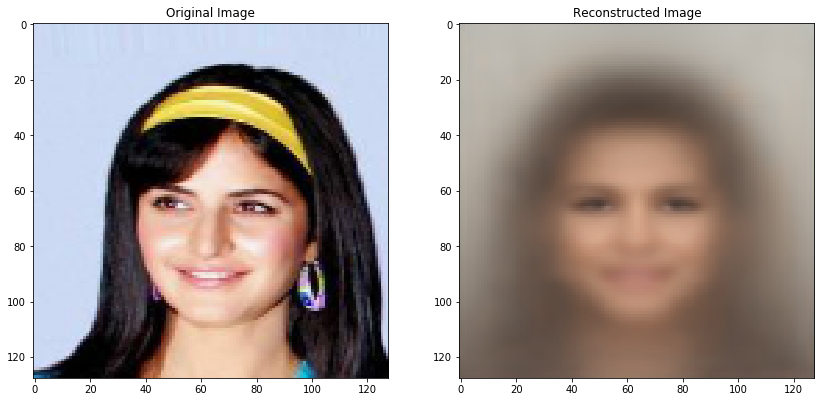

In [34]:
# 1.B.3 Choose a random input image, encode it, then decode the latent representation. Plot the original image and the reconstructed output. How do they compare?

# Randomly choose an image
imgFilename = np.random.choice(list(validData.image_id))
# Load the selected image
img = load_img("data/img_align_celeba/" + imgFilename)
# Convert to an array for plotting
img = img_to_array(img)/255.0

# Resize the original image to match the size used in the VAE
img = skimage.transform.resize(img, (128, 128))
img_single = np.expand_dims(img, axis=0)
img_single = img_single.astype(np.float32)
img_single = np.repeat(img_single, batch_size, axis=0)

# Setup the figure
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(14,8))

# Add to the subplot figure for plotting
ax1.imshow(img)
ax1.set_title("Original Image")

# Get the latent representation of the img
z = encoder.predict(img_single)
# Display the latent representation
print('latent sample:\n', z[0])
# Decode the latent representation
ret = decoder.predict(z)
ax2.imshow(ret[0])
ax2.set_title("Reconstructed Image");


**1.B.3 con't** The reconstructed image doesn't look very much the celebrity in the original image, but the general attributes are there. You can tell that the reconstructed image is female, has non-arched eyebrows, and is smiling. The nose profile is the same, and the forehead is similar too. The hair is too obscured to tell if it's long or short or wavy or straight. 

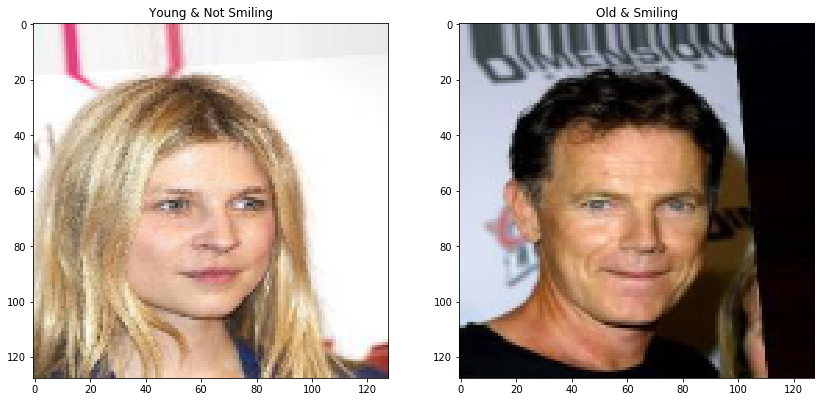

In [107]:
# 1.B.4 Choose two celebrity faces from the dataset that differ according to two attributes
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(14,8))
# Test data is the 1 partition
testData = celebaEval[celebaEval.partition == 1]

# Randomly select an image that is young and not smiling
img1 = np.random.choice(list(celebaAttr[(celebaAttr['Young'] == 1) & (celebaAttr['Smiling'] != 1) & (celebaAttr.image_id.isin(list(testData.image_id)))].image_id))
# Load the selected image
img1 = load_img("data/img_align_celeba/" + img1)    
# Convert to an array for plotting
img1 = img_to_array(img1)/255.0
# Resize the image to 128 x 128
img1 = skimage.transform.resize(img1, (128, 128))
# Add to the subplot figure for plotting
ax1.imshow(img1)
ax1.set_title("Young & Not Smiling");

# Randomly select an image that is old and smiling
img2 = np.random.choice(list(celebaAttr[(celebaAttr['Young'] != 1) & (celebaAttr['Smiling'] == 1) & (celebaAttr.image_id.isin(list(testData.image_id)))].image_id))
# Load the selected image
img2 = load_img("data/img_align_celeba/" + img2)
# Convert to an array for plotting
img2 = img_to_array(img2)/255.0
# Resize the image to 128 x 128
img2 = skimage.transform.resize(img2, (128, 128))
# Add to the subplot figure for plotting
ax2.imshow(img2)
ax2.set_title("Old & Smiling");

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


latent sample for image 1:
 [ 7.046516    0.04942578  8.45933    -1.1125622   1.3834939  -1.8658043
  1.0222212   0.33101442 -4.3472466   0.5789383   8.819202   -1.0833651
 -2.7296457   2.5442443  -0.54251647 -0.4735894 ]
latent sample for image 2:
 [-10.730816     0.09565578  -0.20730817  -2.0276363    1.720412
  -0.64165837   0.6473391   -0.63555545  -1.1442516   -0.08791989
  -0.72734666  -1.6664621   -1.4427478   -2.116046     0.32326245
   0.8410251 ]


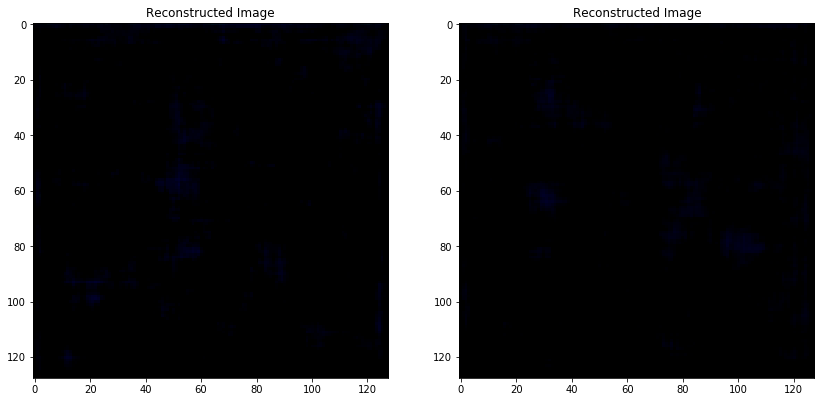

In [108]:
img1 = np.expand_dims(img1, axis=0)
img1 = img1.astype(np.float32)
img1 = np.repeat(img1, batch_size, axis=0)

img2 = np.expand_dims(img2, axis=0)
img2 = img2.astype(np.float32)
img2 = np.repeat(img2, batch_size, axis=0)

# Get the latent representation of the img
z1 = encoder.predict(img1)
z2 = encoder.predict(img2)
# Display the latent representation
print('latent sample for image 1:\n', z1[0])
print('latent sample for image 2:\n', z2[0])
# Decode the latent representation
ret1 = decoder.predict(z1)
ret2 = decoder.predict(z2)

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(14,8))
ax1.imshow(ret1[0])
ax1.set_title("Reconstructed Image");

ax2.imshow(ret2[0])
ax2.set_title("Reconstructed Image");

I ran out of time, and wasn't able to save my model after training the VAE. My Jupyterhub kept disconnecting and interrupting my model training. Overall, based on the latent representation above, the predicted faces will show the main attributes of the face but won't be especially clear. There is a significant amount of training that would help including doing training on the entire dataset. It's tough to do this in limited time with limited resources.

In [ ]:
#1.B.5. Generate and visualise around 15 celebrity faces not in your training set. How do the generated faces compare in quality to celebrity faces from the training samples?


### Part C: Building and Training a DCGAN Model [43 pts]

**1.C.1.** Create and compile a DCGAN model for the celebrity faces dataset.  Print summaries for the discriminator and generator models.

**1.C.2.** Train your model on the images in the celeba dataset.

**1.C.3.** Generate and visualise around 15 celebrity faces.  How do the generated faces compare in quality to celebrity faces from the training samples? How do they compare in quality to the faces generated via VAE?

#### Please note that the DCGAN model can take a long time to train before you obtain good results. Expect to train for more than 2 hrs depending on the batch size and number of epochs

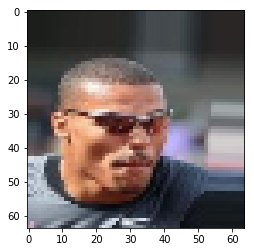

In [80]:
def plot_image(x):
    plt.imshow(x * 0.5 + 0.5)
    
X = []
# Reference to CelebA dataset here.
faces = glob.glob('data/img_align_celeba/*.jpg')

SPATIAL_DIM = 64
NUM_LOAD = 10000 
LATENT_DIM = 100 # Dimensionality of the noise vector.
BATCH_SIZE = 32 # Batchsize to use for training.
DISC_UPDATES = 1  # Number of discriminator updates per training iteration.
GEN_UPDATES = 1 # Nmber of generator updates per training iteration.
FILTER_SIZE = 5 # Filter size to be applied throughout all convolutional layers.
NET_CAPACITY = 16 # General factor to globally change the number of convolutional filters.

PROGRESS_INTERVAL = 80 # Number of iterations after which current samples will be plotted.

for i, f in enumerate(faces):
    img = cv2.imread(f)
    img = cv2.resize(img, (SPATIAL_DIM, SPATIAL_DIM))
    img = np.flip(img, axis=2)
    img = img.astype(np.float32) / 127.5 - 1.0
    X.append(img)
    if i >= NUM_LOAD - 1:
        break
X = np.array(X)
plot_image(X[8888])
X.shape, X.min(), X.max()

ROOT_DIR = 'data' # Directory where generated samples should be saved to.

if not os.path.isdir(ROOT_DIR):
    os.mkdir(ROOT_DIR)

In [83]:
def add_encoder_block(x, filters, filter_size):
    x = Conv2D(filters, filter_size, padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(filters, filter_size, padding='same', strides=2)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.3)(x)
    return x


def build_discriminator(start_filters, spatial_dim, filter_size):
    inp = Input(shape=(spatial_dim, spatial_dim, 3))
    
    # Encoding blocks downsample the image.
    x = add_encoder_block(inp, start_filters, filter_size)
    x = add_encoder_block(x, start_filters * 2, filter_size)
    x = add_encoder_block(x, start_filters * 4, filter_size)
    x = add_encoder_block(x, start_filters * 8, filter_size)
    
    x = GlobalAveragePooling2D()(x)
    x = Dense(1, activation='sigmoid')(x)
    return Model(inputs=inp, outputs=x)

def add_decoder_block(x, filters, filter_size):
    x = Deconvolution2D(filters, filter_size, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.3)(x)
    return x

def build_generator(start_filters, filter_size, latent_dim):
    inp = Input(shape=(latent_dim,))
    
    # Projection.
    x = Dense(4 * 4 * (start_filters * 8), input_dim=latent_dim)(inp)
    x = BatchNormalization()(x)
    x = Reshape(target_shape=(4, 4, start_filters * 8))(x)
    
    # Decoding blocks upsample the image.
    x = add_decoder_block(x, start_filters * 4, filter_size)
    x = add_decoder_block(x, start_filters * 2, filter_size)
    x = add_decoder_block(x, start_filters, filter_size)
    x = add_decoder_block(x, start_filters, filter_size)    
    
    x = Conv2D(3, kernel_size=5, padding='same', activation='tanh')(x)
    return Model(inputs=inp, outputs=x)

In [84]:
# 1.C.1 Create and compile a DCGAN model for the celebrity faces dataset.
def construct_models(verbose=False):
    # 1. Build discriminator.
    discriminator = build_discriminator(NET_CAPACITY, SPATIAL_DIM, FILTER_SIZE)
    discriminator.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002), metrics=['mae'])

    # 2. Build generator.
    generator = build_generator(NET_CAPACITY, FILTER_SIZE, LATENT_DIM)

    # 3. Build full GAN setup by stacking generator and discriminator.
    gan = Sequential()
    gan.add(generator)
    gan.add(discriminator)
    discriminator.trainable = False # Fix the discriminator part in the full setup.
    gan.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002), metrics=['mae'])

    if verbose: # Print model summaries for debugging purposes.
        generator.summary()
        discriminator.summary()
        gan.summary()
    return generator, discriminator, gan


In [91]:
def run_training(start_it=0, num_epochs=1000):
    config_name = 'gan_cap' + str(NET_CAPACITY) + '_batch' + str(BATCH_SIZE) + '_filt' + str(FILTER_SIZE) + '_disc' + str(DISC_UPDATES) + '_gen' + str(GEN_UPDATES)
    folder = os.path.join(ROOT_DIR, config_name)

    if not os.path.isdir(folder):
        os.mkdir(folder)
    avg_loss_discriminator = []
    avg_loss_generator = []
    total_it = start_it

    for epoch in range(num_epochs):
        loss_discriminator = []
        loss_generator = []
        for it in range(200): 

            # Update discriminator.
            for i in range(DISC_UPDATES): 
                # Fetch real examples (you could sample unique entries, too).
                imgs_real = X[np.random.randint(0, X.shape[0], size=BATCH_SIZE)]

                # Generate fake examples.
                noise = np.random.randn(BATCH_SIZE, LATENT_DIM)
                imgs_fake = generator.predict(noise)

                d_loss_real = discriminator.train_on_batch(imgs_real, np.ones([BATCH_SIZE]))[1]
                d_loss_fake = discriminator.train_on_batch(imgs_fake, np.zeros([BATCH_SIZE]))[1]
            
            # Progress visualizations.
            if total_it % PROGRESS_INTERVAL == 0:
                plt.figure(figsize=(5,2))
                # We sample separate images.
                num_vis = min(BATCH_SIZE, 8)
                imgs_real = X[np.random.randint(0, X.shape[0], size=num_vis)]
                noise = np.random.randn(num_vis, LATENT_DIM)
                imgs_fake = generator.predict(noise)
                for obj_plot in [imgs_fake, imgs_real]:
                    plt.figure(figsize=(num_vis * 3, 3))
                    for b in range(num_vis):
                        disc_score = float(discriminator.predict(np.expand_dims(obj_plot[b], axis=0))[0])
                        plt.subplot(1, num_vis, b + 1)
                        plt.title(str(round(disc_score, 3)))
                        plot_image(obj_plot[b]) 
                    if obj_plot is imgs_fake:
                        plt.savefig(os.path.join(folder, str(total_it).zfill(10) + '.jpg'), format='jpg', bbox_inches='tight')
                    plt.show()  

            # Update generator.
            loss = 0
            y = np.ones([BATCH_SIZE, 1]) 
            for j in range(GEN_UPDATES):
                noise = np.random.randn(BATCH_SIZE, LATENT_DIM)
                loss += gan.train_on_batch(noise, y)[1]

            loss_discriminator.append((d_loss_real + d_loss_fake) / 2.)        
            loss_generator.append(loss / GEN_UPDATES)
            total_it += 1

        # Progress visualization.
        clear_output(True)
        print('Epoch', epoch)
        avg_loss_discriminator.append(np.mean(loss_discriminator))
        avg_loss_generator.append(np.mean(loss_generator))
        plt.plot(range(len(avg_loss_discriminator)), avg_loss_discriminator)
        plt.plot(range(len(avg_loss_generator)), avg_loss_generator)
        plt.legend(['discriminator loss', 'generator loss'])
        plt.show()

In [92]:
# 1.C.1 Print summaries for the discriminator and generator models.

In [93]:
generator, discriminator, gan = construct_models(verbose=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        (None, 100)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 2048)              206848    
_________________________________________________________________
batch_normalization_112 (Bat (None, 2048)              8192      
_________________________________________________________________
reshape_5 (Reshape)          (None, 4, 4, 128)         0         
_________________________________________________________________
conv2d_transpose_13 (Conv2DT (None, 8, 8, 64)          204864    
_________________________________________________________________
batch_normalization_113 (Bat (None, 8, 8, 64)          256       
_________________________________________________________________
leaky_re_lu_61 (LeakyReLU)   (None, 8, 8, 64)          0         
__________

Epoch 999


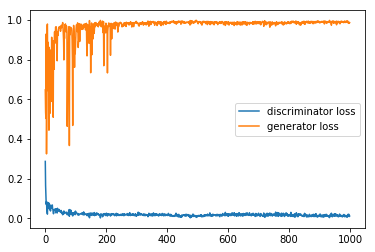

In [94]:
#1.C.2. Train your model on the images in the celeba dataset.
run_training()

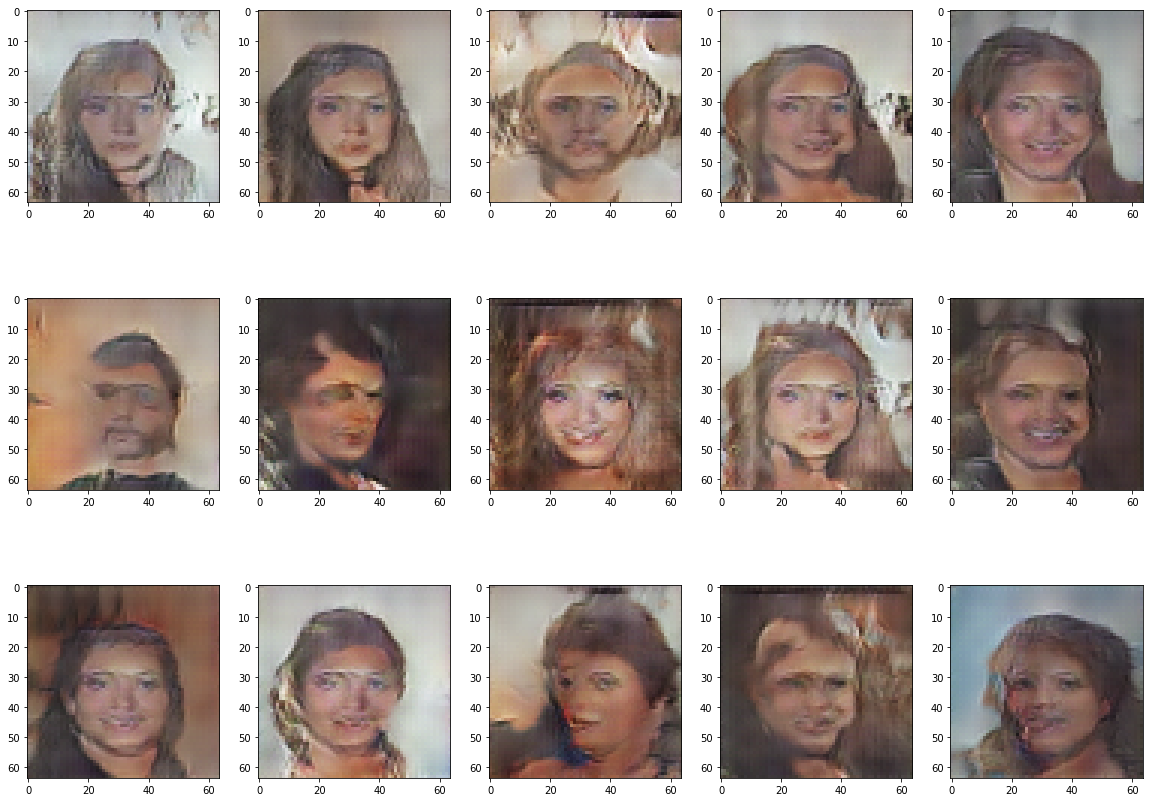

In [100]:
#1.C.3. Generate and visualise around 15 celebrity faces. How do the generated faces compare in quality to celebrity faces from the training samples? How do they compare in quality to the faces generated via VAE?
NUM_SAMPLES = 15
plt.figure(figsize=(20, 15))

for i in range(NUM_SAMPLES):
    noise = np.random.randn(1, LATENT_DIM) 
    pred_raw = generator.predict(noise)[0]
    pred = pred_raw * 0.5 + 0.5
    plt.subplot(3, NUM_SAMPLES/3, i + 1)
    plt.imshow(pred)
plt.show()

The face quality is much better than those output in the latent representation by the VAE. I wasn't able to get the VAE to predict celebrity faces, but when I visualized the latent representation of images output from the VAE, they were sharper but fewer of the attributes of the actual face were predicted. Overall, the attributes and the faces look much better than the output from the VAE. However, there's a long way to go in the improvement of the GAN model.

## Question 2: VAE-GANIME [3 pts - ALMOST OPTIONAL] 

Wikipedia describes [Anime]() as follows:

Anime is hand-drawn and computer animation originating from or associated with Japan.  

The word anime is the Japanese term for animation, which means all forms of animated media. Outside Japan, anime refers specifically to animation from Japan or as a Japanese-disseminated animation style often characterized by colorful graphics, vibrant characters and fantastical themes. The culturally abstract approach to the word's meaning may open up the possibility of anime produced in countries other than Japan For simplicity, many Westerners strictly view anime as a Japanese animation product. Some scholars suggest defining anime as specifically or quintessentially Japanese may be related to a new form of Orientalism

We've provided you a dataset of anime faces and we want you to create a model to generate faces in the same style using a special form of GAN, a VAE-GAN.  The term VAE-GAN was first used by Larsen et. al in their paper [“Autoencoding beyond pixels using a learned similarity metric”](https://arxiv.org/abs/1512.09300).  VAE-GAN models differentiate themselves from GANs in that their generators are variation autoencoders.

![](https://cdn-images-1.medium.com/max/800/0*KEmfTtghsCDu6UTb.png)

### Part A: Preparing the Data [5 pts]

**2.A.1.** Download the dataset from [Anime-Face Dataset](https://s3.amazonaws.com/gec-harvard-dl2-hw2-data/datasets/anime-faces.zip). It contains over 20K anime faces in the form of 64x64 images.  Use them to create your anime face dataset.  Again, you may find it to your advantage to create a [Keras Custom Data Generator](https://techblog.appnexus.com/a-keras-multithreaded-dataframe-generator-for-millions-of-image-files-84d3027f6f43).

### Part B: Building and Training a DCGAN [20 pts]

**2.B.1.** Create and compile a DCGAN model for the anime faces dataset.  Print summaries for the generator and discriminator models

**2.B.2.** Train your model on the images in the anime faces dataset.

**2.B.3.** Generate and visualise around 15 anime faces not in your training set.  How do the generated faces compare in quality to anime faces from the training samples?

### Part C: Building and Training a VAE-GAN [20 pts]

**2.C.1.** Create and compile a VAE-GAN model for the anime faces dataset.  Print summaries for the encoder, decoder and discriminator models

**2.C.2.** Train your model on the images in the anime faces dataset.

**2.C.3.** Generate and visualise around 15 anime faces not in your training set.  How do the generated faces compare in quality to anime faces from the training samples? How do they compare to the faces from the traditional GAN?

#### Please note that the DCGAN model can take a long time to train before you obtain good results. Expect to train for more than 2 hrs depending on the batch size and number of epochs